# Amazon Recommendation System Based On Preview

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [7]:
import kagglehub
import os
import shutil
# Download latest version
path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
data_dir = "./datasets"

os.makedirs(data_dir, exist_ok=True)
shutil.copytree(path, data_dir, dirs_exist_ok=True)

print("Dataset đã được lưu tại:", os.path.abspath(data_dir))

ReadTimeout: HTTPSConnectionPool(host='www.kaggle.com', port=443): Read timed out. (read timeout=5)

## Reading dataset

In [8]:
dataset = pd.read_csv(data_dir+"/amazon.csv")

print(f"Number of rows: {dataset.shape}")
print(f"Number of column: {dataset.columns.tolist()}")

Number of rows: (1465, 16)
Number of column: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']


## Preprocessing dataset

In [9]:
# Checking number of missing value
print(dataset.isna().sum())

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64


## Create preprocessing data function

In [10]:
import re
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

def preprocess_amazon_dataset(dataset):
    print("Starting preprocessing...")
    print(f"Initial dataset shape: {dataset.shape}")
    
    # 1. Check missing values
    print("\nMissing values before preprocessing:")
    print(dataset.isna().sum())
    
    # 2. Clean price and percentage functions
    def clear_special_character(x):
        if pd.isna(x):
            return np.nan
        x = str(x)
        x = re.sub(r"[^0-9.]", "", x)
        return x if x != "" else np.nan

    def clear_price(x):
        x = clear_special_character(x)
        try:
            return float(x)
        except:
            return np.nan
        
    def clear_percent(x):
        x = clear_special_character(x)
        try:
            return float(x) / 100.0
        except:
            return np.nan

    # 3. Apply cleaning to price columns
    price_cols = ["discounted_price", "actual_price"]
    for col in price_cols:
        if col in dataset.columns:
            print(f"Cleaning {col}...")
            dataset[col] = dataset[col].apply(clear_price)
    
    if "discount_percentage" in dataset.columns:
        print("Cleaning discount_percentage...")
        dataset["discount_percentage"] = dataset["discount_percentage"].apply(clear_percent)

    # 4. Convert numeric columns
    numeric_cols = ["discounted_price", "actual_price", "discount_percentage", "rating", "rating_count"]
    existing_numeric_cols = [col for col in numeric_cols if col in dataset.columns]
    
    print(f"Converting to numeric: {existing_numeric_cols}")
    for col in existing_numeric_cols:
        dataset[col] = pd.to_numeric(dataset[col], errors="coerce")

    # 5. Fill missing values
    def fill_missing_auto(df):
        df_filled = df.copy()
        
        for col in df_filled.columns:
            if pd.api.types.is_numeric_dtype(df_filled[col]):
                # Fill numeric columns with median (more robust than mean)
                median_val = df_filled[col].median(skipna=True)
                df_filled[col] = df_filled[col].fillna(median_val)
            else:
                # Fill categorical columns with mode or 'Unknown'
                if df_filled[col].mode().empty:
                    df_filled[col] = df_filled[col].fillna('Unknown')
                else:
                    mode_val = df_filled[col].mode()[0]
                    df_filled[col] = df_filled[col].fillna(mode_val)
        
        return df_filled

    dataset = fill_missing_auto(dataset)
    
    print("\nMissing values after filling:")
    print(dataset.isna().sum())

    # 6. Create price categories BEFORE normalization
    if "actual_price" in dataset.columns:
        print("Creating price categories...")
        # Remove rows with missing actual_price
        dataset = dataset[dataset["actual_price"].notna()].copy()
        
        # Create price categories using quantiles
        try:
            labels = ['Low', 'Medium', 'High', 'Luxury']
            dataset['price_category'] = pd.qcut(
                dataset['actual_price'], 
                q=4, 
                labels=labels, 
                duplicates='drop'
            )
            print("Price category distribution:")
            print(dataset['price_category'].value_counts())
        except Exception as e:
            print(f"Error creating price categories: {e}")
            # Fallback to manual binning
            dataset['price_category'] = pd.cut(
                dataset['actual_price'],
                bins=4,
                labels=['Low', 'Medium', 'High', 'Luxury']
            )

    # 7. Handle categorical variables encoding
    categorical_cols = ['category', 'price_category']
    existing_cat_cols = [col for col in categorical_cols if col in dataset.columns]
    
    print(f"Encoding categorical columns: {existing_cat_cols}")
    label_encoders = {}
    
    for col in existing_cat_cols:
        if dataset[col].dtype == 'object' or dataset[col].dtype.name == 'category':
            le = LabelEncoder()
            # Convert to string first to handle any mixed types
            dataset[col] = dataset[col].astype(str)
            dataset[f'{col}_encoded'] = le.fit_transform(dataset[col])
            label_encoders[col] = le
            print(f"Encoded {col}: {len(le.classes_)} unique values")

    # 8. Normalize numeric features (AFTER creating price categories)
    print("Normalizing numeric features...")
    
    # Only normalize specific columns to avoid issues
    cols_to_normalize = []
    for col in ["discounted_price", "actual_price", "discount_percentage", "rating", "rating_count"]:
        if col in dataset.columns and pd.api.types.is_numeric_dtype(dataset[col]):
            cols_to_normalize.append(col)
    
    if cols_to_normalize:
        scaler = MinMaxScaler()
        # Create normalized versions instead of replacing original
        normalized_data = scaler.fit_transform(dataset[cols_to_normalize])
        
        for i, col in enumerate(cols_to_normalize):
            dataset[f'{col}_normalized'] = normalized_data[:, i]
        
        print(f"Normalized columns: {cols_to_normalize}")
    else:
        print("No numeric columns found for normalization")

    # 9. Create content column for recommendation
    print("Creating content column for recommendations...")
    content_parts = []
    
    if 'product_name' in dataset.columns:
        content_parts.append(dataset['product_name'].astype(str))
    if 'category' in dataset.columns:
        content_parts.append(dataset['category'].astype(str))
    if 'about_product' in dataset.columns:
        content_parts.append(dataset['about_product'].astype(str))
    
    if content_parts:
        dataset['content'] = ' '.join(content_parts[0] if len(content_parts) == 1 else [' '.join(parts) for parts in zip(*content_parts)])
    else:
        print("Warning: Could not create content column - missing text columns")

    # 10. Final validation
    print("\nFinal dataset info:")
    print(f"Shape: {dataset.shape}")
    print(f"Columns: {list(dataset.columns)}")
    
    # Check required columns for recommendations
    required_cols = ["product_id", "user_id", "rating"]
    missing_required = [col for col in required_cols if col not in dataset.columns]
    if missing_required:
        print(f"Warning: Missing required columns for recommendations: {missing_required}")
    
    # Ensure product_id and user_id are strings
    if 'product_id' in dataset.columns:
        dataset['product_id'] = dataset['product_id'].astype(str)
    if 'user_id' in dataset.columns:
        dataset['user_id'] = dataset['user_id'].astype(str)
    
    print("Preprocessing completed!")
    return dataset, label_encoders, scaler if 'scaler' in locals() else None

# Additional utility functions
def validate_dataset_for_recommendations(dataset):
    """Validate dataset has required columns for recommendation system"""
    required_cols = {
        'basic': ['product_id', 'product_name'],
        'content_based': ['product_id', 'product_name', 'category', 'about_product'],
        'collaborative': ['user_id', 'product_id', 'rating'],
        'hybrid': ['user_id', 'product_id', 'rating', 'product_name', 'category']
    }
    
    print("Dataset validation for recommendation systems:")
    print("=" * 50)
    
    for rec_type, cols in required_cols.items():
        missing = [col for col in cols if col not in dataset.columns]
        if not missing:
            print(f"✓ {rec_type.upper()}: All required columns present")
        else:
            print(f"✗ {rec_type.upper()}: Missing columns - {missing}")
    
    print(f"\nDataset shape: {dataset.shape}")
    print(f"Unique products: {dataset['product_id'].nunique() if 'product_id' in dataset.columns else 'N/A'}")
    print(f"Unique users: {dataset['user_id'].nunique() if 'user_id' in dataset.columns else 'N/A'}")
    
    if 'rating' in dataset.columns:
        print(f"Rating range: {dataset['rating'].min():.2f} - {dataset['rating'].max():.2f}")
        print(f"Average rating: {dataset['rating'].mean():.2f}")

def check_data_quality(dataset):
    """Check data quality issues"""
    print("Data Quality Check:")
    print("=" * 30)
    
    # Check duplicates
    if 'product_id' in dataset.columns and 'user_id' in dataset.columns:
        duplicates = dataset.duplicated(subset=['product_id', 'user_id']).sum()
        print(f"Duplicate user-product pairs: {duplicates}")
    
    # Check rating distribution
    if 'rating' in dataset.columns:
        print("\nRating distribution:")
        print(dataset['rating'].value_counts().sort_index())
    
    # Check for extreme values
    numeric_cols = dataset.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        q99 = dataset[col].quantile(0.99)
        q01 = dataset[col].quantile(0.01)
        outliers = ((dataset[col] > q99) | (dataset[col] < q01)).sum()
        if outliers > 0:
            print(f"Potential outliers in {col}: {outliers} ({outliers/len(dataset)*100:.1f}%)")

# Usage example:
# processed_dataset, encoders, scaler = preprocess_amazon_dataset(dataset)
# validate_dataset_for_recommendations(processed_dataset)
# check_data_quality(processed_dataset)

In [ ]:
processed_dataset, encoders, scaler = preprocess_amazon_dataset(dataset)

Starting preprocessing...
Initial dataset shape: (1465, 16)

Missing values before preprocessing:
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64
Cleaning discounted_price...
Cleaning actual_price...
Cleaning discount_percentage...
Converting to numeric: ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']

Missing values after filling:
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name    

In [12]:
validate_dataset_for_recommendations(processed_dataset)

Dataset validation for recommendation systems:
✓ BASIC: All required columns present
✓ CONTENT_BASED: All required columns present
✓ COLLABORATIVE: All required columns present
✓ HYBRID: All required columns present

Dataset shape: (1465, 25)
Unique products: 1351
Unique users: 1194
Rating range: 2.00 - 5.00
Average rating: 4.10


In [13]:
check_data_quality(processed_dataset)

Data Quality Check:
Duplicate user-product pairs: 104

Rating distribution:
rating
2.0      1
2.3      1
2.6      1
2.8      2
2.9      1
3.0      4
3.1      4
3.2      2
3.3     16
3.4     10
3.5     26
3.6     35
3.7     42
3.8     86
3.9    123
4.0    181
4.1    245
4.2    228
4.3    230
4.4    123
4.5     75
4.6     17
4.7      6
4.8      3
5.0      3
Name: count, dtype: int64
Potential outliers in discounted_price: 30 (2.0%)
Potential outliers in actual_price: 29 (2.0%)
Potential outliers in discount_percentage: 15 (1.0%)
Potential outliers in rating: 26 (1.8%)
Potential outliers in rating_count: 30 (2.0%)
Potential outliers in category_encoded: 27 (1.8%)
Potential outliers in discounted_price_normalized: 30 (2.0%)
Potential outliers in actual_price_normalized: 29 (2.0%)
Potential outliers in discount_percentage_normalized: 15 (1.0%)
Potential outliers in rating_normalized: 26 (1.8%)
Potential outliers in rating_count_normalized: 30 (2.0%)


## Create price_category

In [14]:
dataset = dataset[dataset["actual_price"].notna()].copy()

labels = ['Low', 'Medium', 'High', 'Luxury']
dataset['price_category'] = pd.qcut(dataset['actual_price'], q=4, labels=labels, duplicates='drop')

print(dataset['price_category'].value_counts())

price_category
Low       368
High      366
Luxury    366
Medium    365
Name: count, dtype: int64


In [ ]:
features = ["discounted_price", "discount_percentage", "rating", "rating_count", "category"]
for c in features:
    if c not in dataset.columns:
        raise ValueError(f"Missing column: {c}")

## One-hot encode category

In [16]:
X = dataset[features].copy()
X = pd.get_dummies(X, columns=["category"], prefix="cat", dummy_na=False)

y = dataset["price_category"]
print("X shape:", X.shape)
print("Example features:", X.columns.tolist()[:10])

X shape: (1465, 215)
Example features: ['discounted_price', 'discount_percentage', 'rating', 'rating_count', 'cat_Car&Motorbike|CarAccessories|InteriorAccessories|AirPurifiers&Ionizers', 'cat_Computers&Accessories|Accessories&Peripherals|Adapters|USBtoUSBAdapters', 'cat_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCHeadsets', 'cat_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCMicrophones', 'cat_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|PCSpeakers', 'cat_Computers&Accessories|Accessories&Peripherals|Audio&VideoAccessories|Webcams&VoIPEquipment|Webcams']


## Split into training test and test set

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (1172, 215) Test size: (293, 215)


## Baseline: Random Forest Classification

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced", n_jobs = -1)
clf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluation model

Accuracy: 0.89419795221843

Classification Report:
               precision    recall  f1-score   support

        High       0.90      0.82      0.86        73
         Low       0.92      0.95      0.93        74
      Luxury       0.96      0.97      0.97        73
      Medium       0.80      0.84      0.82        73

    accuracy                           0.89       293
   macro avg       0.89      0.89      0.89       293
weighted avg       0.89      0.89      0.89       293



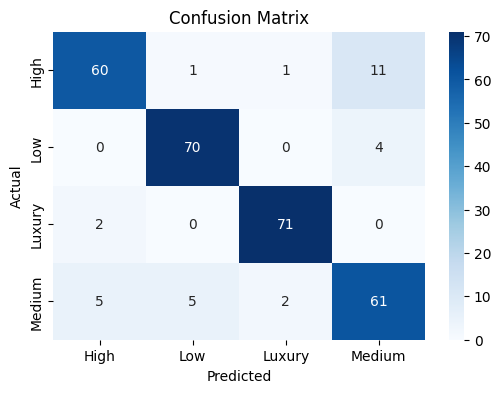

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Building Recommendation System

### Tf-idf Vectorization 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Merge content columns
dataset["content"] = (
    dataset["product_name"]+ " " +
    dataset["category"] + " " +
    dataset["about_product"]
)

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(dataset["content"])

# Tính cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

try:
    # for scipy sparse matrix .toarray exists
    if hasattr(cosine_sim, "toarray"):
        cosine_sim = cosine_sim.toarray().astype(float)
    else:
        cosine_sim = np.array(cosine_sim, dtype=float)
except Exception:
    cosine_sim = np.array(cosine_sim, dtype=float)

# mapping product_id -> row index (use str for consistency)
dataset["product_id"] = dataset["product_id"].astype(str)
indices = pd.Series(dataset.index, index=dataset["product_id"]).drop_duplicates()


In [ ]:
def recommend_content_based(product_id, top_n=5):
    product_id = str(product_id)
    if product_id not in indices:
        print(f"Product ID {product_id} not found in dataset")
        return pd.DataFrame()

    idx = indices[product_id]
    if idx >= len(dataset) or idx >= cosine_sim.shape[0]:
        print(f"Index {idx} is out of bounds")
        return pd.DataFrame()

    sim_vector = cosine_sim[idx]
    if sim_vector.ndim > 1:
        sim_vector = sim_vector.flatten()

    sim_scores = list(enumerate(sim_vector))

    print(f"DEBUG sim_scores sample: {sim_scores[:5]}")
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    valid_indices = []
    for i, score in sim_scores:
        if 0 <= i < len(dataset):
            valid_indices.append(i)
        else:
            print(f"Warning: Index {i} is out of bounds, skipping")
    
    if not valid_indices:
        print("No valid recommendations found")
        return pd.DataFrame()

    # Return recommendations using valid indices only
    return dataset.iloc[valid_indices][
        ["product_id", "product_name", "category", "product_link"]
    ].head(top_n)

### Collaborative Filtering 

In [ ]:
# Installing the surprise
!pip install surprise

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Tạo user-item matrix
ratings = dataset[["user_id", "product_id", "rating"]].dropna().copy()
user_item_matrix = ratings.pivot_table(index="user_id", columns="product_id", values="rating").fillna(0)

# Tính similarity giữa các items (dựa trên vector user-rating)
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# CF recommend (item-based)
def recommend_collaborative(user_id, top_n=5):
    if user_id not in user_item_matrix.index:
        return []

    user_ratings = user_item_matrix.loc[user_id]
    scores = {}

    # Duyệt qua các item mà user đã rated
    for item, rating in user_ratings[user_ratings > 0].items():
        similar_items = item_similarity_df[item].drop(item)
        for sim_item, sim_score in similar_items.items():
            if user_ratings[sim_item] == 0:  # chưa rated
                scores[sim_item] = scores.get(sim_item, 0) + sim_score * rating

    # Lấy top_n
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    product_ids = [iid for iid, _ in sorted_scores]
    
    return dataset[dataset["product_id"].isin(product_ids)][["product_id", "product_name", "category", "product_link"]]


# Combine to hybrid recommendation system

In [ ]:
def recommend_hybrid(user_id, product_id, top_n=5, alpha=0.5):
    if product_id not in indices or user_id not in user_item_matrix.index:
        return []

    # Content-based similarity
    idx = indices[product_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:50]  # lấy 50 sp tương tự
    
    hybrid_scores = []
    for i, sim in sim_scores:
        iid = dataset.iloc[i]["product_id"]

        # CF score: similarity trung bình với sp user đã rating
        user_ratings = user_item_matrix.loc[user_id]
        cf_score = 0
        if iid in item_similarity_df.columns:
            for rated_item, rating in user_ratings[user_ratings > 0].items():
                cf_score += item_similarity_df.loc[iid, rated_item] * rating

        hybrid_score = alpha * sim + (1 - alpha) * cf_score
        hybrid_scores.append((iid, hybrid_score))

    # Top N
    hybrid_scores = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:top_n]
    product_ids = [iid for iid, _ in hybrid_scores]
    
    return dataset[dataset["product_id"].isin(product_ids)][["product_id", "product_name", "category", "product_link"]]


In [ ]:
# COMPLETE RECOMMENDATION SYSTEM - READY TO RUN
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# =============================================================================
# 1. PREPROCESSING FUNCTIONS
# =============================================================================

def preprocess_amazon_dataset(dataset):
    """Complete preprocessing pipeline"""
    print("Starting preprocessing...")
    print(f"Initial dataset shape: {dataset.shape}")
    
    # Clean price functions
    def clear_special_character(x):
        if pd.isna(x):
            return np.nan
        x = str(x)
        x = re.sub(r"[^0-9.]", "", x)
        return x if x != "" else np.nan

    def clear_price(x):
        x = clear_special_character(x)
        try:
            return float(x)
        except:
            return np.nan
        
    def clear_percent(x):
        x = clear_special_character(x)
        try:
            return float(x) / 100.0
        except:
            return np.nan

    # Clean price columns
    price_cols = ["discounted_price", "actual_price"]
    for col in price_cols:
        if col in dataset.columns:
            dataset[col] = dataset[col].apply(clear_price)
    
    if "discount_percentage" in dataset.columns:
        dataset["discount_percentage"] = dataset["discount_percentage"].apply(clear_percent)

    # Convert to numeric
    numeric_cols = ["discounted_price", "actual_price", "discount_percentage", "rating", "rating_count"]
    existing_numeric_cols = [col for col in numeric_cols if col in dataset.columns]
    
    for col in existing_numeric_cols:
        dataset[col] = pd.to_numeric(dataset[col], errors="coerce")

    # Fill missing values
    def fill_missing_auto(df):
        df_filled = df.copy()
        for col in df_filled.columns:
            if pd.api.types.is_numeric_dtype(df_filled[col]):
                median_val = df_filled[col].median(skipna=True)
                df_filled[col] = df_filled[col].fillna(median_val)
            else:
                if df_filled[col].mode().empty:
                    df_filled[col] = df_filled[col].fillna('Unknown')
                else:
                    mode_val = df_filled[col].mode()[0]
                    df_filled[col] = df_filled[col].fillna(mode_val)
        return df_filled

    dataset = fill_missing_auto(dataset)

    # Create price categories BEFORE normalization
    if "actual_price" in dataset.columns:
        dataset = dataset[dataset["actual_price"].notna()].copy()
        try:
            labels = ['Low', 'Medium', 'High', 'Luxury']
            dataset['price_category'] = pd.qcut(dataset['actual_price'], q=4, labels=labels, duplicates='drop')
        except:
            dataset['price_category'] = pd.cut(dataset['actual_price'], bins=4, labels=['Low', 'Medium', 'High', 'Luxury'])

    # Encode categorical variables
    if 'category' in dataset.columns:
        le = LabelEncoder()
        dataset['category'] = dataset['category'].astype(str)
        dataset['category_encoded'] = le.fit_transform(dataset['category'])

    # Ensure string types for IDs
    if 'product_id' in dataset.columns:
        dataset['product_id'] = dataset['product_id'].astype(str)
    if 'user_id' in dataset.columns:
        dataset['user_id'] = dataset['user_id'].astype(str)

    # Create content column for recommendations
    content_parts = []
    if 'product_name' in dataset.columns:
        content_parts.append(dataset['product_name'].astype(str))
    if 'category' in dataset.columns:
        content_parts.append(dataset['category'].astype(str))
    if 'about_product' in dataset.columns:
        content_parts.append(dataset['about_product'].astype(str))
    
    if content_parts:
        dataset['content'] = content_parts[0]
        for part in content_parts[1:]:
            dataset['content'] += " " + part

    # Normalize numeric features (keep original for price categories)
    cols_to_normalize = [col for col in existing_numeric_cols if col in dataset.columns]
    if cols_to_normalize:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(dataset[cols_to_normalize])
        for i, col in enumerate(cols_to_normalize):
            dataset[f'{col}_normalized'] = normalized_data[:, i]

    print(f"✅ Preprocessing completed! Final shape: {dataset.shape}")
    return dataset

# =============================================================================
# 2. RECOMMENDATION SYSTEM
# =============================================================================

class RecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset.copy()
        self.tfidf = None
        self.tfidf_matrix = None
        self.cosine_sim = None
        self.user_item_matrix = None
        self.item_similarity_df = None
        self.indices = None
        
        self._build_system()
    
    def _build_system(self):
        """Build all recommendation components"""
        print("🔨 Building recommendation system...")
        
        # Prepare data
        if 'product_id' not in self.dataset.columns:
            raise ValueError("Missing product_id column")
        
        self.dataset['product_id'] = self.dataset['product_id'].astype(str)
        self.indices = pd.Series(self.dataset.index, index=self.dataset['product_id']).drop_duplicates()
        
        # Build content-based components
        if 'content' in self.dataset.columns:
            self._build_content_based()
        else:
            print("⚠️ No content column found, skipping content-based filtering")
        
        # Build collaborative filtering components
        if all(col in self.dataset.columns for col in ['user_id', 'rating']):
            self._build_collaborative()
        else:
            print("⚠️ Missing user_id or rating columns, skipping collaborative filtering")
    
    def _build_content_based(self):
        """Build content-based filtering"""
        print("📝 Building content-based filtering...")
        
        self.tfidf = TfidfVectorizer(stop_words="english", max_features=5000, ngram_range=(1, 2))
        self.tfidf_matrix = self.tfidf.fit_transform(self.dataset['content'])
        self.cosine_sim = linear_kernel(self.tfidf_matrix, self.tfidf_matrix)
        
        # Convert to dense array
        if hasattr(self.cosine_sim, "toarray"):
            self.cosine_sim = self.cosine_sim.toarray()
    
    def _build_collaborative(self):
        """Build collaborative filtering"""
        print("👥 Building collaborative filtering...")
        
        ratings = self.dataset[['user_id', 'product_id', 'rating']].dropna()
        if ratings.empty:
            return
        
        self.user_item_matrix = ratings.pivot_table(
            index='user_id', columns='product_id', values='rating'
        ).fillna(0)
        
        if not self.user_item_matrix.empty:
            item_similarity = cosine_similarity(self.user_item_matrix.T)
            self.item_similarity_df = pd.DataFrame(
                item_similarity,
                index=self.user_item_matrix.columns,
                columns=self.user_item_matrix.columns
            )
    
    def recommend_content_based(self, product_id, top_n=5):
        """Content-based recommendations"""
        if self.cosine_sim is None:
            return pd.DataFrame()
        
        product_id = str(product_id)
        if product_id not in self.indices:
            return pd.DataFrame()
        
        idx = self.indices[product_id]
        if idx >= len(self.dataset):
            return pd.DataFrame()
        
        sim_scores = list(enumerate(self.cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
        
        valid_indices = [i for i, _ in sim_scores if 0 <= i < len(self.dataset)]
        
        if not valid_indices:
            return pd.DataFrame()
        
        result = self.dataset.iloc[valid_indices].copy()
        result['similarity_score'] = [score for _, score in sim_scores[:len(valid_indices)]]
        
        return result[['product_id', 'product_name', 'category', 'similarity_score']].head(top_n)
    
    def recommend_collaborative(self, user_id, top_n=5):
        """Collaborative filtering recommendations"""
        if self.user_item_matrix is None or self.item_similarity_df is None:
            return pd.DataFrame()
        
        if user_id not in self.user_item_matrix.index:
            return pd.DataFrame()
        
        user_ratings = self.user_item_matrix.loc[user_id]
        scores = {}
        
        for item, rating in user_ratings[user_ratings > 0].items():
            if item in self.item_similarity_df.columns:
                similar_items = self.item_similarity_df[item].drop(item, errors='ignore')
                for sim_item, sim_score in similar_items.items():
                    if user_ratings.get(sim_item, 0) == 0:
                        scores[sim_item] = scores.get(sim_item, 0) + sim_score * rating
        
        if not scores:
            return pd.DataFrame()
        
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        recommendations = []
        for product_id, score in sorted_scores:
            product_info = self.dataset[self.dataset['product_id'] == product_id]
            if not product_info.empty:
                product_info = product_info.iloc[0]
                recommendations.append({
                    'product_id': product_id,
                    'product_name': product_info['product_name'],
                    'category': product_info['category'],
                    'cf_score': score
                })
        
        return pd.DataFrame(recommendations)
    
    def recommend_hybrid(self, user_id, product_id, top_n=5, alpha=0.6):
        """Hybrid recommendations"""
        product_id = str(product_id)
        
        if product_id not in self.indices:
            return pd.DataFrame()
        
        if (self.user_item_matrix is None or user_id not in self.user_item_matrix.index):
            return self.recommend_content_based(product_id, top_n)
        
        idx = self.indices[product_id]
        if idx >= self.cosine_sim.shape[0]:
            return pd.DataFrame()
        
        sim_scores = list(enumerate(self.cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:51]
        
        user_ratings = self.user_item_matrix.loc[user_id]
        hybrid_scores = []
        
        for i, content_sim in sim_scores:
            if i >= len(self.dataset):
                continue
                
            iid = self.dataset.iloc[i]['product_id']
            
            cf_score = 0
            cf_count = 0
            
            if iid in self.item_similarity_df.columns:
                for rated_item, rating in user_ratings[user_ratings > 0].items():
                    if rated_item in self.item_similarity_df.index:
                        similarity = self.item_similarity_df.loc[iid, rated_item]
                        cf_score += similarity * rating
                        cf_count += 1
            
            if cf_count > 0:
                cf_score = cf_score / cf_count
            
            hybrid_score = alpha * content_sim + (1 - alpha) * cf_score
            hybrid_scores.append((iid, hybrid_score))
        
        if not hybrid_scores:
            return pd.DataFrame()
        
        hybrid_scores = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:top_n]
        
        recommendations = []
        for product_id, score in hybrid_scores:
            product_info = self.dataset[self.dataset['product_id'] == product_id]
            if not product_info.empty:
                product_info = product_info.iloc[0]
                recommendations.append({
                    'product_id': product_id,
                    'product_name': product_info['product_name'],
                    'category': product_info['category'],
                    'hybrid_score': score
                })
        
        return pd.DataFrame(recommendations)

# =============================================================================
# 3. MAIN EXECUTION SCRIPT
# =============================================================================

def run_complete_system(dataset):
    """Run the complete recommendation system"""
    print("=" * 60)
    print("🎯 AMAZON RECOMMENDATION SYSTEM")
    print("=" * 60)
    
    # Step 1: Preprocess data
    processed_dataset = preprocess_amazon_dataset(dataset)
    
    # Step 2: Initialize recommendation system
    rec_system = RecommendationSystem(processed_dataset)
    
    # Step 3: Get test data
    if len(processed_dataset) == 0:
        print("❌ Dataset is empty!")
        return None
    
    test_product = processed_dataset['product_id'].iloc[0]
    test_user = processed_dataset['user_id'].iloc[0] if 'user_id' in processed_dataset.columns else None
    
    print(f"\n🧪 Testing with:")
    print(f"   Product: {test_product}")
    if test_user:
        print(f"   User: {test_user}")
    
    # Step 4: Test recommendations
    print("\n" + "="*60)
    print("📊 RECOMMENDATION RESULTS")
    print("="*60)
    
    # Content-based recommendations
    print("\n1️⃣ CONTENT-BASED RECOMMENDATIONS")
    print("-" * 40)
    content_recs = rec_system.recommend_content_based(test_product, top_n=5)
    if not content_recs.empty:
        for idx, row in content_recs.iterrows():
            print(f"   📦 {row['product_name'][:50]}...")
            print(f"       Category: {row['category']} | Score: {row['similarity_score']:.3f}")
    else:
        print("   ❌ No content-based recommendations available")
    
    # Collaborative filtering
    if test_user:
        print("\n2️⃣ COLLABORATIVE FILTERING RECOMMENDATIONS")
        print("-" * 40)
        cf_recs = rec_system.recommend_collaborative(test_user, top_n=5)
        if not cf_recs.empty:
            for idx, row in cf_recs.iterrows():
                print(f"   👤 {row['product_name'][:50]}...")
                print(f"       Category: {row['category']} | Score: {row['cf_score']:.3f}")
        else:
            print("   ❌ No collaborative filtering recommendations available")
        
        # Hybrid recommendations
        print("\n3️⃣ HYBRID RECOMMENDATIONS")
        print("-" * 40)
        hybrid_recs = rec_system.recommend_hybrid(test_user, test_product, top_n=5, alpha=0.6)
        if not hybrid_recs.empty:
            for idx, row in hybrid_recs.iterrows():
                print(f"   🔗 {row['product_name'][:50]}...")
                print(f"       Category: {row['category']} | Score: {row['hybrid_score']:.3f}")
        else:
            print("   ❌ No hybrid recommendations available")
    
    print("\n✅ System testing completed!")
    return rec_system, processed_dataset

# =============================================================================
# 4. RUN THE SYSTEM
# =============================================================================

# Uncomment the line below to run with your dataset:
# rec_system, processed_data = run_complete_system(dataset)

print("🚀 RECOMMENDATION SYSTEM READY!")
print("📝 To run the system, execute:")
print("   rec_system, processed_data = run_complete_system(dataset)")

🚀 RECOMMENDATION SYSTEM READY!
📝 To run the system, execute:
   rec_system, processed_data = run_complete_system(dataset)


In [ ]:
rec_system, processed_data = run_complete_system(dataset)

🎯 AMAZON RECOMMENDATION SYSTEM
🚀 Starting preprocessing...
Initial dataset shape: (1465, 16)
✅ Preprocessing completed! Final shape: (1465, 24)
🔨 Building recommendation system...
📝 Building content-based filtering...
👥 Building collaborative filtering...

🧪 Testing with:
   Product: B07JW9H4J1
   User: AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBBSNLYT3ONILA,AHCTC6ULH4XB6YHDY6PCH2R772LQ,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,AENGU523SXMOS7JPDTW52PNNVWGQ,AEQJHCVTNINBS4FKTBGQRQTGTE5Q,AFC3FFC5PKFF5PMA52S3VCHOZ5FQ

📊 RECOMMENDATION RESULTS

1️⃣ CONTENT-BASED RECOMMENDATIONS
----------------------------------------


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().